In [22]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
from algorithm import change_hair_color_realistic, change_hair_color_best
from typing import Union, Dict, Tuple

In [11]:
import cv2
import numpy as np

def apply_hsv_transform_to_target_color(image_bgr, mask, target_hsv):
    """
    Transforms the average HSV color of a masked object to a target HSV color.

    Parameters:
        image_bgr (np.ndarray): Input image in BGR format.
        mask (np.ndarray): Binary mask (uint8, 0 or 255) of shape (H, W).
        target_hsv (tuple): Target HSV color (H, S, V), with H in [0,179], S,V in [0,255].

    Returns:
        np.ndarray: Transformed image in BGR format.
    """
    # Convert image to HSV and to float32
    image_hsv = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2HSV).astype(np.float32)

    # Normalize mask to binary [0, 1]
    mask_bool = (mask > 0).astype(np.uint8)
    mask_float = mask_bool.astype(np.float32)

    # Compute average HSV in masked region
    mask_area = np.sum(mask_float)
    if mask_area == 0:
        raise ValueError("Mask is empty")

    mean_h = np.sum(image_hsv[:, :, 0] * mask_float) / mask_area
    mean_s = np.sum(image_hsv[:, :, 1] * mask_float) / mask_area
    mean_v = np.sum(image_hsv[:, :, 2] * mask_float) / mask_area
    mean_hsv = np.array([mean_h, mean_s, mean_v])

    target_hsv = np.array(target_hsv, dtype=np.float32)

    # Compute linear scale (alpha) to map mean_hsv → target_hsv
    with np.errstate(divide='ignore', invalid='ignore'):
        alpha = np.where(mean_hsv != 0, target_hsv / mean_hsv, 1.0)

    # Optionally clamp H scale to keep hue shifts reasonable
    alpha[0] = np.clip(alpha[0], 0.1, 5.0)

    # Expand alpha and mask for broadcasting
    alpha_arr = alpha.reshape(1, 1, 3)
    mask_3d = np.repeat(mask_float[:, :, np.newaxis], 3, axis=2)

    # Apply linear transformation in masked region
    transformed_hsv = image_hsv * (1 - mask_3d) + image_hsv * alpha_arr * mask_3d

    # Clamp values
    transformed_hsv[:, :, 0] = np.clip(transformed_hsv[:, :, 0], 0, 179)  # H
    transformed_hsv[:, :, 1] = np.clip(transformed_hsv[:, :, 1], 0, 255)  # S
    transformed_hsv[:, :, 2] = np.clip(transformed_hsv[:, :, 2], 0, 255)  # V

    # Convert back to BGR
    transformed_hsv = transformed_hsv.astype(np.uint8)
    result_bgr = cv2.cvtColor(transformed_hsv, cv2.COLOR_HSV2BGR)

    return result_bgr


In [12]:
img_dirs = sorted(glob.glob("data/img/*"))
mask_dirs =  sorted(glob.glob("data/masks/*"))

In [68]:
idx = 2

# Hair is 83
image = cv2.imread(img_dirs[idx])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
mask = cv2.imread(mask_dirs[idx], cv2.IMREAD_GRAYSCALE)
hair_mask = np.where(mask==83, 255, 0).astype(np.uint8)

In [69]:
def analyse_region_colour(
    image: np.ndarray,
    mask: np.ndarray,
    bins: Tuple[int, int, int] = (180, 256, 256)
) -> Dict[str, Tuple[np.ndarray, np.ndarray]]:
    """
    Compute the H, S, V histograms of the masked region in an RGB image.

    Parameters:
        image (np.ndarray): Input image in RGB format, shape (H, W, 3), dtype=uint8.
        mask (np.ndarray): Binary mask, shape (H, W), dtype=uint8 or bool.
                           Non-zero (or True) pixels define the region of interest.
        bins (tuple): Number of bins for H, S and V channels respectively.
                      Defaults to (180, 256, 256).

    Returns:
        Dict[str, (hist, bin_edges)]:  
            'H': (hist_H, edges_H)  
            'S': (hist_S, edges_S)  
            'V': (hist_V, edges_V)  
        Each `hist_*` is a 1D array of counts, and `edges_*` the corresponding bin edges.
    """
    # Ensure mask is boolean
    mask_bool = mask.astype(bool)

    # Convert RGB→HSV
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

    # Extract per-channel values under the mask
    h_vals = hsv[:, :, 0][mask_bool].ravel()
    s_vals = hsv[:, :, 1][mask_bool].ravel()
    v_vals = hsv[:, :, 2][mask_bool].ravel()

    if h_vals.size == 0:
        raise ValueError("Mask selects no pixels")

    # Compute histograms
    hist_h, edges_h = np.histogram(h_vals, bins=bins[0], range=(0, 180))
    hist_s, edges_s = np.histogram(s_vals, bins=bins[1], range=(0, 256))
    hist_v, edges_v = np.histogram(v_vals, bins=bins[2], range=(0, 256))

    return {
        'H': (hist_h, edges_h),
        'S': (hist_s, edges_s),
        'V': (hist_v, edges_v)
    }

In [70]:
region_colour_dict = analyse_region_colour(image, hair_mask)

In [74]:
region_colour_dict["H"][0]

array([   475,      5,    294,    413,    171,  15572,  12284,   7780,
        76713,  36120,  43121, 154014,  70528, 233187, 120767, 188433,
       119946, 172353, 103098, 107219,  59298,  48951,  21886,  16475,
        11273,  10168,  11676,    403,    746,    656,  16223,    148,
          613,    573,   2869,   6003,   8168,     97,    262,    145,
          743,     32,   4764,   2555,     36,     63,    120,      6,
          177,     51,   9520,    692,     73,     23,     43,   2122,
          120,     34,     19,     11,    724,      9,      5,     37,
            3,     19,   3520,      4,     16,      8,   1770,      0,
            0,    737,    107,   2278,      1,      0,      0,    634,
         3486,      0,      0,   2674,    144,    943,      0,   2787,
          178,      0,   2485,      0,    197,    706,      0,   1129,
          706,      0,    349,     64,     97,    345,     95,     99,
           20,      2,      1,      0,      0,      0,     57,      0,
      

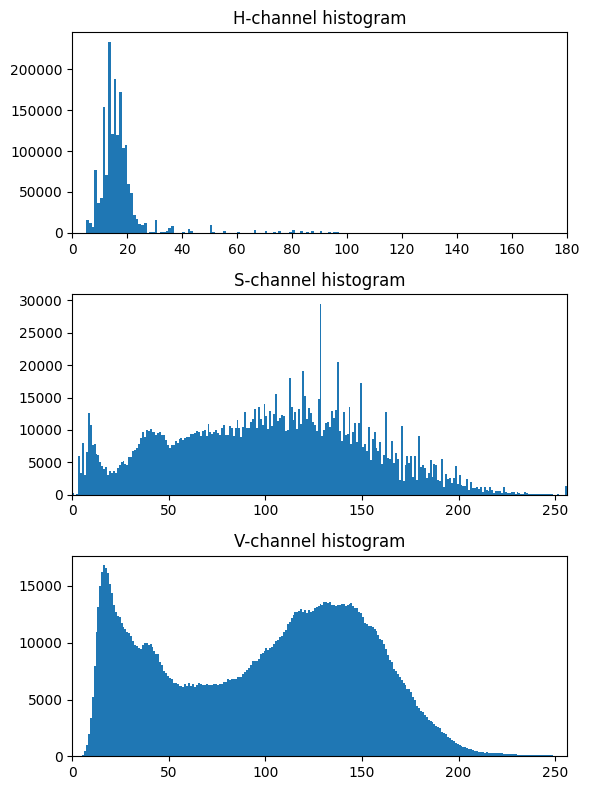

In [75]:
fig, axes = plt.subplots(3, 1, figsize = (6, 8))
for ax, channel in zip(axes, ("H", "S", "V")):
    hist, edges = region_colour_dict[channel]
    centers = (edges[:-1] + edges[1:]) / 2
    ax.bar(centers, hist, width=edges[1] - edges[0])
    ax.set_title(f"{channel}-channel histogram")
    ax.set_xlim(edges[0], edges[-1])
    
plt.tight_layout()
plt.show()

In [76]:
def apply_hsv_channel_offset(
    image_bgr: np.ndarray,
    mask: np.ndarray,
    dh: float = 0,
    ds: float = 0,
    dv: float = 0
) -> np.ndarray:
    """
    Add constant offsets to H, S, V channels inside a mask.

    Parameters:
        image_bgr (np.ndarray): Input image in BGR (uint8).
        mask (np.ndarray): Binary mask (0 or 255), shape (H, W).
        dh (float): Offset to add to Hue (wrapped mod 180).
        ds (float): Offset to add to Saturation (clamped 0–255).
        dv (float): Offset to add to Value (clamped 0–255).

    Returns:
        np.ndarray: Resulting BGR image (uint8).
    """
    # Convert to HSV float32
    hsv = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2HSV).astype(np.float32)

    # 2D boolean mask
    mask_bool = (mask > 0)

    # Channel-wise apply offsets under mask
    # Hue channel (0): wrap modulo 180
    h = hsv[:, :, 0]
    h[mask_bool] = (h[mask_bool] + dh) % 180

    # Saturation channel (1): clamp 0–255
    s = hsv[:, :, 1]
    s[mask_bool] = np.clip(s[mask_bool] + ds, 0, 255)

    # Value channel (2): clamp 0–255
    v = hsv[:, :, 2]
    v[mask_bool] = np.clip(v[mask_bool] + dv, 0, 255)

    # Write back and convert
    hsv[:, :, 0] = h
    hsv[:, :, 1] = s
    hsv[:, :, 2] = v

    hsv = hsv.astype(np.uint8)
    return cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)

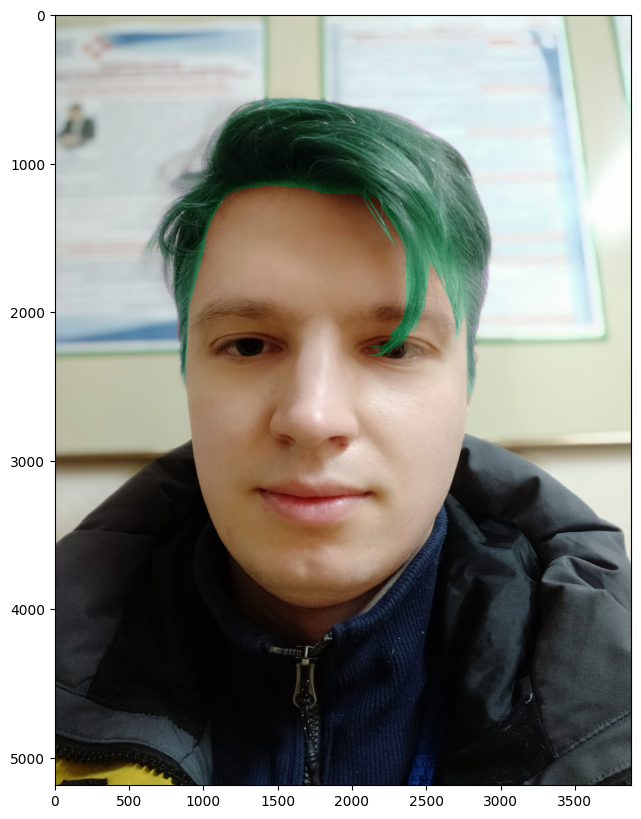

In [82]:
plt.figure(figsize = (20, 10))
plt.imshow(apply_hsv_channel_offset(image, hair_mask, dh=120, ds=10, dv=0))